In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

def get_image_paths(directory):
    image_paths = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".png"):
                image_paths.append(os.path.join(subdir, file))
    return image_paths

dataset_directory = '/kaggle/input/data'
image_paths = get_image_paths(dataset_directory)
csv_file_path = '/kaggle/input/data/Data_Entry_2017.csv'
data_entry = pd.read_csv(csv_file_path)

image_name_to_path_dict = {os.path.basename(path): path for path in image_paths}
filtered_data_entry = data_entry[data_entry['Image Index'].isin(image_name_to_path_dict.keys())]
filtered_data_entry['Full Image Path'] = filtered_data_entry['Image Index'].apply(lambda x: image_name_to_path_dict[x])

mlb = MultiLabelBinarizer()
labels_list = filtered_data_entry['Finding Labels'].str.split('|').tolist()
encoded_labels = mlb.fit_transform(labels_list)

tf_dataset = pd.DataFrame({
    'Image Path': filtered_data_entry['Full Image Path'],
    'Labels': [tuple(label) for label in encoded_labels],  # Convert arrays to tuples
    'Patient ID': filtered_data_entry['Patient ID']
})

# Limit the number of images per class
class_limit = 1400

def limit_images_per_class(df):
    dfs = []
    for _, group_df in df.groupby('Labels'):
        sample_df = group_df.sample(n=min(len(group_df), class_limit), random_state=42)
        dfs.append(sample_df)
    return pd.concat(dfs, ignore_index=True)

tf_dataset_limited = limit_images_per_class(tf_dataset)

# Splitting dataset based on patient IDs
def split_based_on_patients(df, train_frac=0.6, val_frac=0.2):
    patient_ids = df['Patient ID'].unique()
    np.random.seed(42)
    np.random.shuffle(patient_ids)

    train_idx = int(len(patient_ids) * train_frac)
    val_idx = train_idx + int(len(patient_ids) * val_frac)

    train_patients = patient_ids[:train_idx]
    val_patients = patient_ids[train_idx:val_idx]
    test_patients = patient_ids[val_idx:]

    train_df = df[df['Patient ID'].isin(train_patients)]
    val_df = df[df['Patient ID'].isin(val_patients)]
    test_df = df[df['Patient ID'].isin(test_patients)]

    return train_df, val_df, test_df

train_df, val_df, test_df = split_based_on_patients(tf_dataset_limited)

def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [240, 240])
    image = image / 255.0
    label = tf.cast(label, dtype=tf.float32)
    return image, label

# Creating datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['Image Path'].values, np.vstack(train_df['Labels'].values)))
train_dataset = train_dataset.map(parse_image).shuffle(buffer_size=1000).batch(32)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_df['Image Path'].values, np.vstack(val_df['Labels'].values)))
validation_dataset = validation_dataset.map(parse_image).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((test_df['Image Path'].values, np.vstack(test_df['Labels'].values)))
test_dataset = test_dataset.map(parse_image).batch(32)

# Generating class weights for each of the 15 classes
all_labels = np.vstack(train_df['Labels'].values)
label_counts = np.sum(all_labels, axis=0)
total_samples = all_labels.shape[0]
class_weights = {i: total_samples / (15 * label_counts[i]) for i in range(15)}


In [6]:
class_weights

{0: 0.27845143362384744,
 1: 0.9105741429161504,
 2: 0.5346186492057718,
 3: 1.0284581292278983,
 4: 0.2290984671343206,
 5: 0.950625269512721,
 6: 1.4551155115511551,
 7: 11.757333333333333,
 8: 0.20977257588733467,
 9: 0.46924223073648363,
 10: 1.7706827309236948,
 11: 0.4928459646769506,
 12: 0.7246877054569362,
 13: 1.7109041521148622,
 14: 0.5455332838406335}

In [16]:
import matplotlib.pyplot as plt

def plot_samples(df, title):
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=16)

    # Select 20 random samples
    sample_df = df.sample(20, random_state=14)

    for i, row in enumerate(sample_df.itertuples(), 1):
        img = tf.io.read_file(row._1)  # Using row._1 to access the 'Image Path' attribute
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, [240, 240])

        # Decode labels
        labels = mlb.inverse_transform(np.array([row.Labels]))[0]

        # Plot
        plt.subplot(4, 5, i)
        plt.imshow(img.numpy().squeeze(), cmap='gray')
        plt.title(", ".join(labels))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

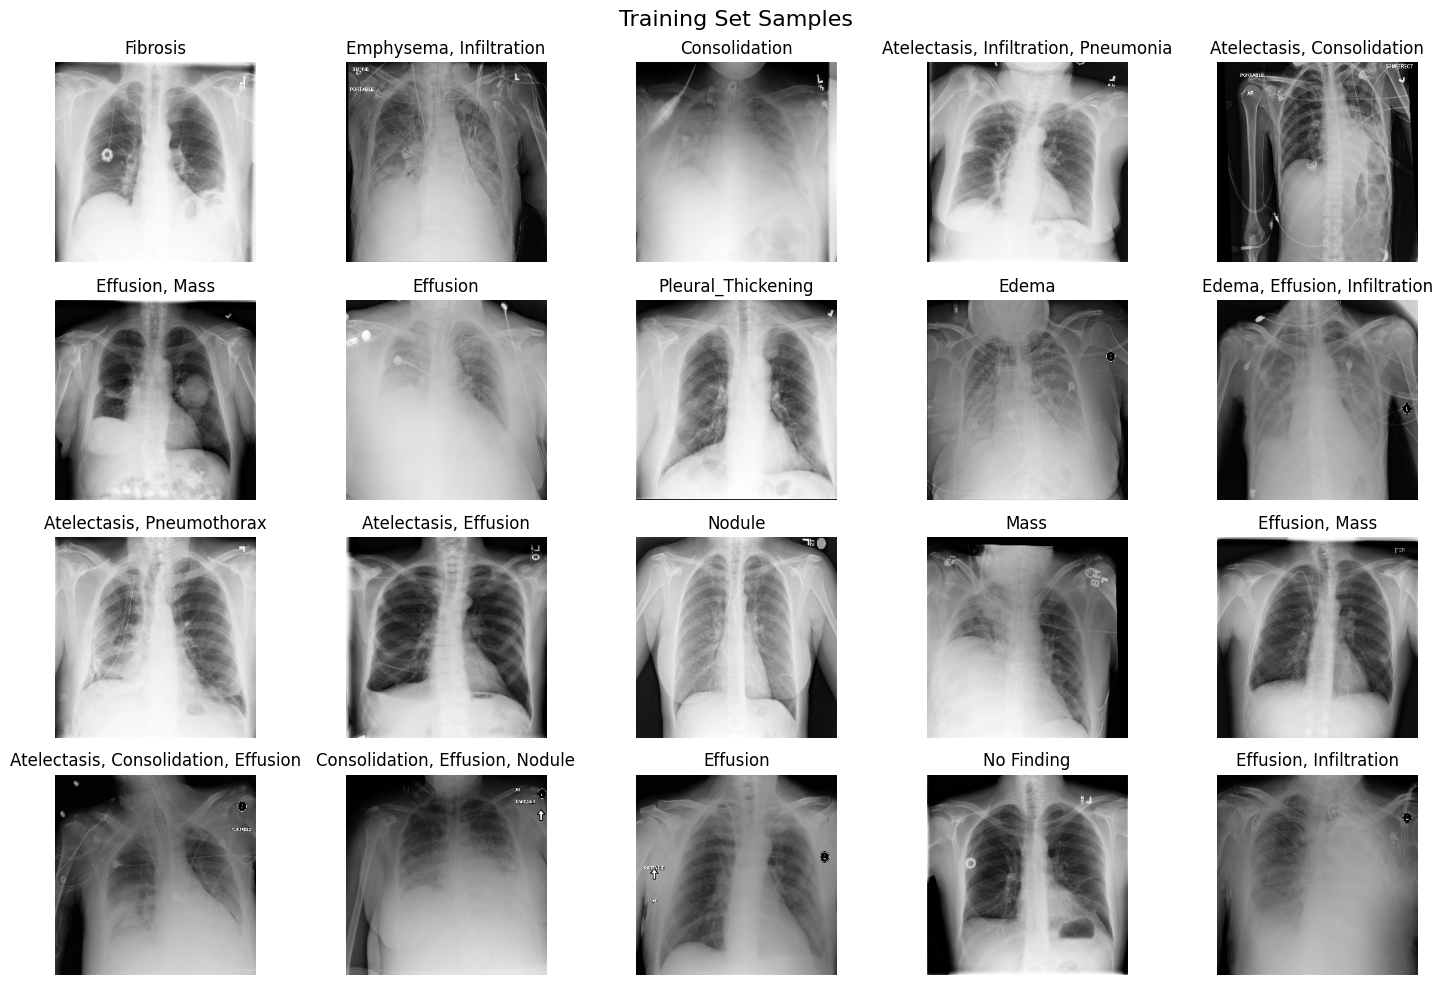

In [17]:
plot_samples(train_df, 'Training Set Samples')

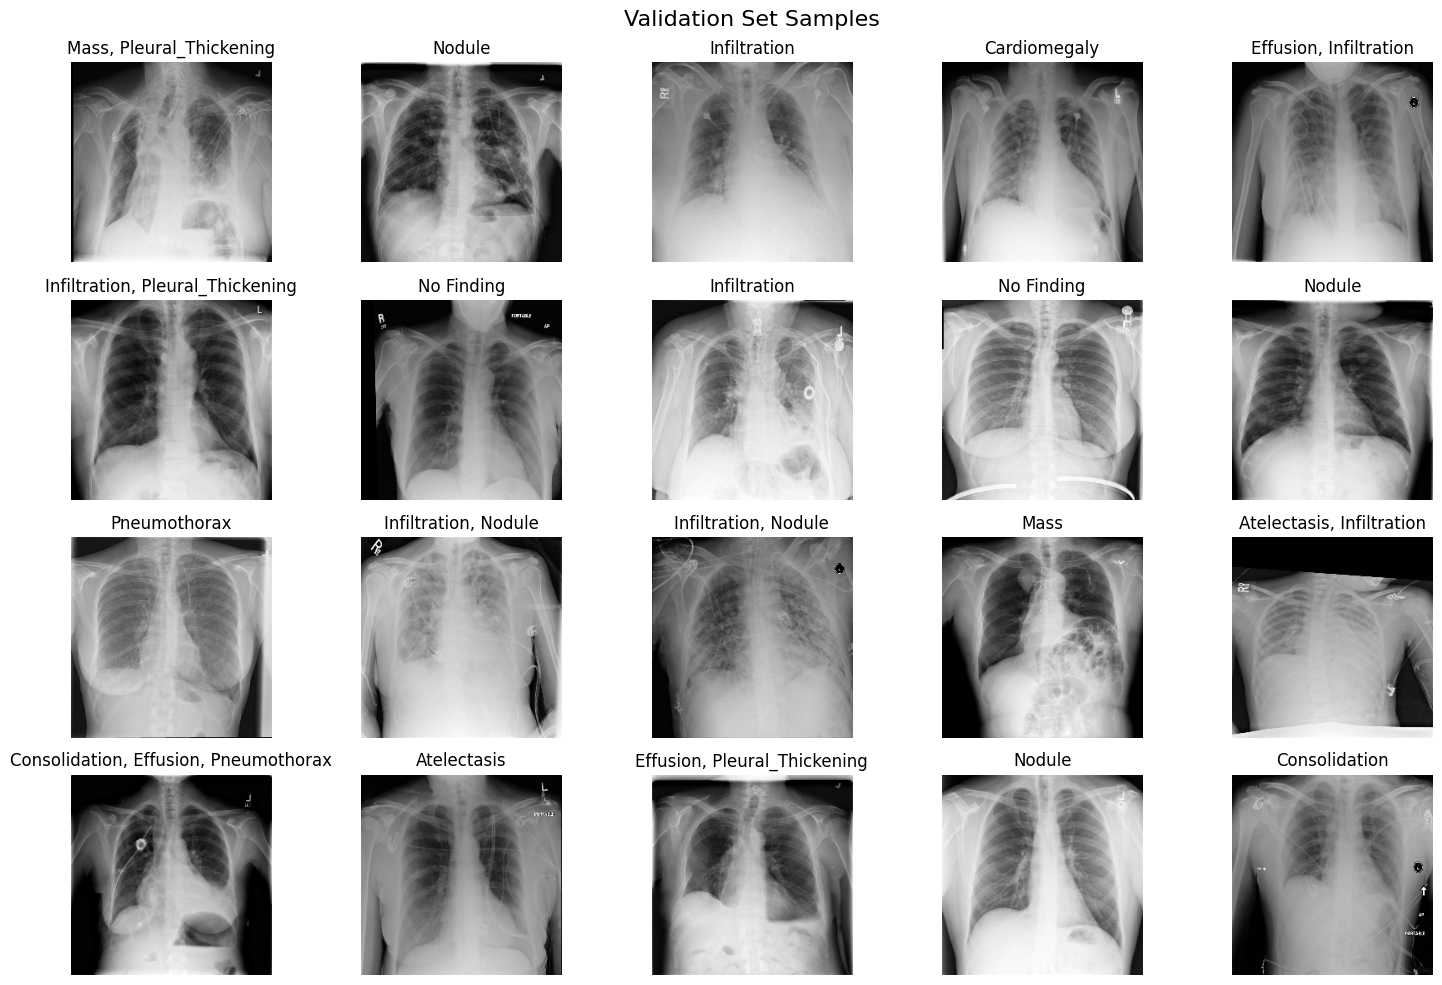

In [18]:
plot_samples(val_df, 'Validation Set Samples')

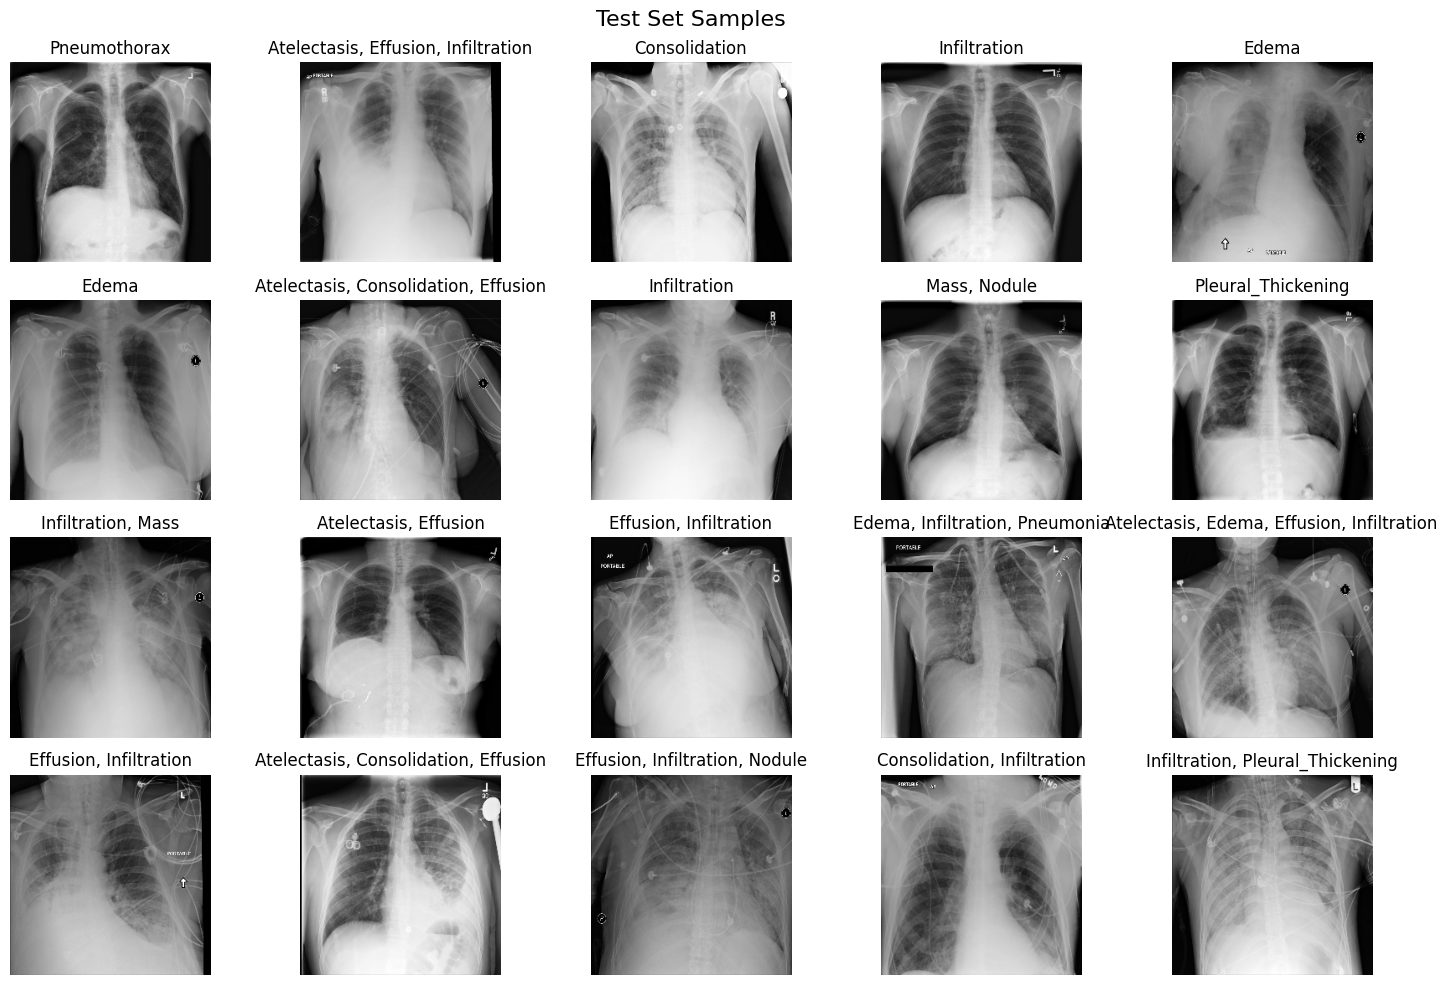

In [19]:
plot_samples(test_df, 'Test Set Samples')

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

In [21]:
all_labels = data_entry['Finding Labels'].str.split('|').explode().unique()
num_classes = len(all_labels)

In [22]:
all_labels

array(['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation'], dtype=object)

In [ ]:
"""x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='SAME')(inputs)
x = Conv2D(64, kernel_size=(3, 3),padding='SAME')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(64, kernel_size=(3, 3),padding='SAME')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)


x = Conv2D(32, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(32, kernel_size=(3, 3),padding='SAME')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(32, kernel_size=(3, 3),padding='SAME')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)"""

In [23]:
inputs= keras.Input(shape=(240, 240,1))


x = Conv2D(128, kernel_size=(3, 3), activation='relu',padding='SAME')(inputs)
x = Conv2D(128, kernel_size=(3, 3),padding='SAME')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(64, kernel_size=(3, 3),padding='SAME')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)



x = Conv2D(32, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(32, kernel_size=(3, 3),padding='SAME')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(16, kernel_size=(3, 3),padding='SAME')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)


x = Flatten(name='flatten')(x)
x = Dense(units=300, activation='relu')(x)
outputs = Dense(units=num_classes, activation='sigmoid')(x)
model= keras.Model(inputs=inputs, outputs=outputs)

In [5]:
all_labels

array(['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation'], dtype=object)

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [8]:
"""import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer


csv_file_path = '/kaggle/input/data/Data_Entry_2017.csv'
data_entry = pd.read_csv(csv_file_path)

labels = data_entry['Finding Labels'].str.split('|').tolist()

mlb = MultiLabelBinarizer()
mlb.fit(labels)

binary_labels = mlb.transform(labels)

class_counts = binary_labels.sum(axis=0)
n_samples = len(labels)

class_weights = (n_samples / class_counts)

min_weight = min(class_weights)
class_weights_normalized = class_weights / min_weight

class_weights = {i: weight for i, weight in enumerate(class_weights_normalized)}

class_weights"""


{0: 5.221991521757937,
 1: 21.743876080691642,
 2: 12.93357617313049,
 3: 26.209726443768997,
 4: 4.532627468649094,
 5: 23.99085850556439,
 6: 35.801304863582445,
 7: 265.90748898678413,
 8: 3.0341308937368052,
 9: 10.439467312348668,
 10: 1.0,
 11: 9.534196809350814,
 12: 17.831905465288035,
 13: 42.18099231306779,
 14: 11.384571859675594}

In [25]:
class_counts

NameError: name 'class_counts' is not defined

In [26]:
model.compile(
  optimizer='adam',
  loss=tf.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

In [27]:
def get_early_stopping():
    
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
     
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=6, min_lr=0.000001)

In [28]:
from tensorflow import keras

In [29]:
checkpoint_filepath = "./checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
)

In [30]:
early_stopping = get_early_stopping()

callbacks = [checkpoint_callback, reduce_lr]

In [ ]:
history = model.fit(train_dataset, validation_data=validation_dataset, batch_size=32, epochs=30,
                    class_weight=class_weights, callbacks=callbacks)

Epoch 1/30


2024-01-01 00:02:17.312463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 59/689 [=>............................] - ETA: 7:42 - loss: 0.1513 - accuracy: 0.4041